In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

from src.HNN.hnn import train_hnn, simulate_hnn, compute_derivatives_torch 
from src.HNN.custom_emlp_hnn import *
from src.HNN.pendulum_dataset import *

import warnings
warnings.filterwarnings('ignore')

/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate dataset 
# data_dict = generate_pendulum_dataset(
#         save_path='./data/pendulum_dataset.pkl',
#         num_trajectories=10,  # Smaller number for quick testing
#         random_seed=42,
#         test_split=0.2
#     )

# Load the simple pendulum dataset
print("Loading simple pendulum dataset...")
with open('Data/pendulum_dataset.pkl', 'rb') as file:
    data_dict = pickle.load(file)

metadata = data_dict['metadata']


Loading simple pendulum dataset...


In [3]:
metadata = data_dict['metadata']
print('Metadata: ',metadata.keys())

Metadata:  dict_keys(['mass', 'g', 'length', 'damping', 't_span', 'num_steps', 't_eval'])


In [4]:
coords = data_dict['states'] 
test_coords = data_dict['test_states']
dt = (metadata['t_span'][1] - metadata['t_span'][0]) / metadata['num_steps']

print(f"Coordinates shape: {coords.shape}")
print(f"Test coordinates shape: {test_coords.shape}")
print(f"Time step: {dt}")

Coordinates shape: (1600, 100, 2)
Test coordinates shape: (400, 100, 2)
Time step: 0.1


In [5]:
# Extract position (q) and calculate momentum (p = m*v)
q = torch.tensor(coords[:, :, 0], dtype=torch.float32)
p = torch.tensor(coords[:, :, 1], dtype=torch.float32) * metadata['mass']  # Convert velocity to momentum

q_test = torch.tensor(test_coords[:, :, 0], dtype=torch.float32)
p_test = torch.tensor(test_coords[:, :, 1], dtype=torch.float32) * metadata['mass']

In [6]:
print(f"Position (q) shape: {q.shape}")
print(f"Momentum (p) shape: {p.shape}")
print(f"Test position shape: {q_test.shape}")
print(f"Test momentum shape: {p_test.shape}")

Position (q) shape: torch.Size([1600, 100])
Momentum (p) shape: torch.Size([1600, 100])
Test position shape: torch.Size([400, 100])
Test momentum shape: torch.Size([400, 100])


In [7]:
# Compute derivatives for training
print("Computing derivatives...")
dq_dt, dp_dt = compute_derivatives_torch(q, p, dt)
dq_dt_test, dp_dt_test = compute_derivatives_torch(q_test, p_test, dt)

print(f"Position derivative shape: {dq_dt.shape}")
print(f"Momentum derivative shape: {dp_dt.shape}")


Computing derivatives...
Position derivative shape: torch.Size([1600, 100])
Momentum derivative shape: torch.Size([1600, 100])


In [8]:
# Flatten and prepare training data
# We'll create (position, momentum) state vectors and corresponding derivative vectors
states = torch.stack([q.reshape(-1), p.reshape(-1)], dim=1)
test_states = torch.stack([q_test.reshape(-1), p_test.reshape(-1)], dim=1)

true_derivatives = torch.stack([dq_dt.reshape(-1), dp_dt.reshape(-1)], dim=1)
test_true_derivatives = torch.stack([dq_dt_test.reshape(-1), dp_dt_test.reshape(-1)], dim=1)

print(f"Training states shape: {states.shape}")
print(f"Training derivatives shape: {true_derivatives.shape}")
print(f"Test states shape: {test_states.shape}")
print(f"Test derivatives shape: {test_true_derivatives.shape}")

# Verify data integrity
print("\nVerifying data integrity:")
print(f"Any NaN in states: {torch.isnan(states).any()}")
print(f"Any Inf in states: {torch.isinf(states).any()}")
print(f"Any NaN in derivatives: {torch.isnan(true_derivatives).any()}")
print(f"Any Inf in derivatives: {torch.isinf(true_derivatives).any()}")

# Enable gradients
states.requires_grad = True
test_states.requires_grad = True

Training states shape: torch.Size([160000, 2])
Training derivatives shape: torch.Size([160000, 2])
Test states shape: torch.Size([40000, 2])
Test derivatives shape: torch.Size([40000, 2])

Verifying data integrity:
Any NaN in states: False
Any Inf in states: False
Any NaN in derivatives: False
Any Inf in derivatives: False


In [9]:
train_size = 1000
test_size = 200

# Sample accordingly
train_indices = np.random.choice(len(states), size=train_size, replace=False)
test_indices = np.random.choice(len(test_states), size=test_size, replace=False)

# train_dataset = Subset(train_dataset,train_indices)
# test_dataset = Subset(test_dataset,test_indices) 

states = states[train_indices]
true_derivatives = true_derivatives[train_indices] 

test_states = test_states[test_indices] 
test_true_derivatives = test_true_derivatives[test_indices]

In [10]:
# Initializing the symmetry groups 
n_dim = 2
n_channel = 1

lie_algebra = get_generators(n_dim,n_channel,'saved_model/LaLieGAN/pendulum/pendulum_generator_99.pt','pendulum')
G = CustomGroup(n_dim,lie_algebra) 

None


In [11]:
G.lie_algebra

Array([[[ 2.7054553e-03, -7.5726545e-01],
        [ 7.1239080e+00,  4.7761565e-05]]], dtype=float32)

In [12]:
print("\nTraining HNN model...")
batch_size = 128
epochs = 200
lr = 1e-3  # Lowered learning rate for better stability
input_dim = 2  # (q, p)
hidden_dim = 128  # Increased hidden dimension for more capacity

model_hnn, stats_hnn = train_hnn(
    states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, hidden_dim,
    output_dim=1  # IMPORTANT: Hamiltonian should be a scalar function
) 


Training HNN model...
Using Device : cuda:3
Starting training: 200 epochs
Epoch 1/200, Train Loss: 25.346677, Test Loss: 27.092192
Epoch 11/200, Train Loss: 18.009900, Test Loss: 17.649548
Epoch 21/200, Train Loss: 1.814039, Test Loss: 1.471726
Epoch 31/200, Train Loss: 0.160628, Test Loss: 0.127329
Epoch 41/200, Train Loss: 0.076423, Test Loss: 0.063102
Epoch 51/200, Train Loss: 0.053474, Test Loss: 0.046168
Epoch 61/200, Train Loss: 0.042317, Test Loss: 0.035227
Epoch 71/200, Train Loss: 0.035465, Test Loss: 0.025724
Epoch 81/200, Train Loss: 0.032639, Test Loss: 0.022795
Epoch 91/200, Train Loss: 0.028639, Test Loss: 0.018732
Epoch 101/200, Train Loss: 0.025932, Test Loss: 0.016898
Epoch 111/200, Train Loss: 0.025856, Test Loss: 0.016285
Epoch 121/200, Train Loss: 0.021229, Test Loss: 0.013528
Epoch 131/200, Train Loss: 0.020258, Test Loss: 0.012490
Epoch 141/200, Train Loss: 0.019524, Test Loss: 0.013995
Epoch 151/200, Train Loss: 0.023837, Test Loss: 0.016076
Epoch 161/200, Train

In [13]:
print("\nTraining EMLP HNN model with discovered symmetries...")

rep = 1 

model_hnn_emlp, stats_hnn_emlp = train_hnn_emlp(
    G, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, rep, hidden_dim,
    num_layers=3, debug=False
)


Training EMLP HNN model with discovered symmetries...
Starting training: 200 epochs


  2%|▏         | 4/200 [00:39<24:21,  7.45s/it]  

Epoch 1/200 | Train Loss: 25.315286 | Test Loss: 27.118243 | Grad Norm: 0.000000


  8%|▊         | 16/200 [00:39<02:29,  1.23it/s]

Epoch 11/200 | Train Loss: 25.397167 | Test Loss: 27.118243 | Grad Norm: 0.000000


 12%|█▎        | 25/200 [00:40<00:48,  3.63it/s]

Epoch 21/200 | Train Loss: 25.294427 | Test Loss: 27.118243 | Grad Norm: 0.000000


 17%|█▋        | 34/200 [00:40<00:19,  8.51it/s]

Epoch 31/200 | Train Loss: 25.366524 | Test Loss: 27.118243 | Grad Norm: 0.000000


 23%|██▎       | 46/200 [00:40<00:08, 17.38it/s]

Epoch 41/200 | Train Loss: 25.375719 | Test Loss: 27.118243 | Grad Norm: 0.000000


 28%|██▊       | 55/200 [00:41<00:06, 22.11it/s]

Epoch 51/200 | Train Loss: 25.320847 | Test Loss: 27.118243 | Grad Norm: 0.000000


 32%|███▏      | 64/200 [00:41<00:05, 24.90it/s]

Epoch 61/200 | Train Loss: 25.349558 | Test Loss: 27.118243 | Grad Norm: 0.000000


 38%|███▊      | 76/200 [00:42<00:04, 26.53it/s]

Epoch 71/200 | Train Loss: 25.357656 | Test Loss: 27.118243 | Grad Norm: 0.000000


 42%|████▎     | 85/200 [00:42<00:04, 26.95it/s]

Epoch 81/200 | Train Loss: 25.339439 | Test Loss: 27.118243 | Grad Norm: 0.000000


 47%|████▋     | 94/200 [00:42<00:03, 27.07it/s]

Epoch 91/200 | Train Loss: 25.322226 | Test Loss: 27.118243 | Grad Norm: 0.000000


 53%|█████▎    | 106/200 [00:43<00:03, 27.00it/s]

Epoch 101/200 | Train Loss: 25.388496 | Test Loss: 27.118243 | Grad Norm: 0.000000


 57%|█████▊    | 115/200 [00:43<00:03, 27.08it/s]

Epoch 111/200 | Train Loss: 25.268134 | Test Loss: 27.118243 | Grad Norm: 0.000000


 62%|██████▏   | 124/200 [00:43<00:02, 27.04it/s]

Epoch 121/200 | Train Loss: 25.343519 | Test Loss: 27.118243 | Grad Norm: 0.000000


 66%|██████▋   | 133/200 [00:44<00:02, 26.99it/s]

Epoch 131/200 | Train Loss: 25.382261 | Test Loss: 27.118243 | Grad Norm: 0.000000


 72%|███████▎  | 145/200 [00:44<00:02, 23.50it/s]

Epoch 141/200 | Train Loss: 25.332398 | Test Loss: 27.118243 | Grad Norm: 0.000000


 77%|███████▋  | 154/200 [00:45<00:02, 22.46it/s]

Epoch 151/200 | Train Loss: 25.355465 | Test Loss: 27.118243 | Grad Norm: 0.000000


 82%|████████▏ | 163/200 [00:45<00:01, 22.07it/s]

Epoch 161/200 | Train Loss: 25.314989 | Test Loss: 27.118243 | Grad Norm: 0.000000


 88%|████████▊ | 175/200 [00:46<00:01, 22.50it/s]

Epoch 171/200 | Train Loss: 25.335799 | Test Loss: 27.118243 | Grad Norm: 0.000000


 92%|█████████▏| 184/200 [00:46<00:00, 22.45it/s]

Epoch 181/200 | Train Loss: 25.379802 | Test Loss: 27.118243 | Grad Norm: 0.000000


 98%|█████████▊| 196/200 [00:46<00:00, 25.78it/s]

Epoch 191/200 | Train Loss: 25.356267 | Test Loss: 27.118243 | Grad Norm: 0.000000


100%|██████████| 200/200 [00:47<00:00,  4.25it/s]

Epoch 200/200 | Train Loss: 25.303885 | Test Loss: 27.118243 | Grad Norm: 0.000000


In [14]:
print("\nTraining EMLP HNN model with original symmetries...")

rep = 1

from emlp.groups import SO 
Gt = SO(2)

model_hnn_emlp_t, stats_hnn_emlp_t = train_hnn_emlp(
    Gt, states, true_derivatives, 
    test_states, test_true_derivatives,
    batch_size, epochs, lr, 
    input_dim, rep, hidden_dim,
    num_layers=3, debug=False
)


Training EMLP HNN model with original symmetries...
Starting training: 200 epochs


  2%|▎         | 5/200 [00:29<14:22,  4.43s/it]  

Epoch 1/200 | Train Loss: 25.331631 | Test Loss: 27.092495 | Grad Norm: 0.126081


  8%|▊         | 17/200 [00:29<02:09,  1.41it/s]

Epoch 11/200 | Train Loss: 11.504622 | Test Loss: 12.103206 | Grad Norm: 6.991751


 12%|█▎        | 25/200 [00:30<00:55,  3.14it/s]

Epoch 21/200 | Train Loss: 11.450984 | Test Loss: 12.186173 | Grad Norm: 5.709612


 18%|█▊        | 37/200 [00:30<00:19,  8.30it/s]

Epoch 31/200 | Train Loss: 11.485836 | Test Loss: 12.111907 | Grad Norm: 6.635789


 22%|██▎       | 45/200 [00:30<00:11, 13.53it/s]

Epoch 41/200 | Train Loss: 11.479026 | Test Loss: 12.113711 | Grad Norm: 5.816765


 28%|██▊       | 57/200 [00:31<00:06, 21.99it/s]

Epoch 51/200 | Train Loss: 11.423271 | Test Loss: 12.110312 | Grad Norm: 4.469402


 32%|███▎      | 65/200 [00:31<00:05, 26.06it/s]

Epoch 61/200 | Train Loss: 11.435311 | Test Loss: 12.092970 | Grad Norm: 3.795319


 38%|███▊      | 77/200 [00:31<00:04, 29.65it/s]

Epoch 71/200 | Train Loss: 11.432509 | Test Loss: 12.115859 | Grad Norm: 4.828654


 42%|████▎     | 85/200 [00:31<00:03, 32.35it/s]

Epoch 81/200 | Train Loss: 11.475840 | Test Loss: 12.137645 | Grad Norm: 6.038821


 48%|████▊     | 97/200 [00:32<00:02, 36.46it/s]

Epoch 91/200 | Train Loss: 11.446918 | Test Loss: 12.100684 | Grad Norm: 3.696543


 52%|█████▎    | 105/200 [00:32<00:02, 37.49it/s]

Epoch 101/200 | Train Loss: 11.423513 | Test Loss: 12.089802 | Grad Norm: 2.992059


 58%|█████▊    | 117/200 [00:32<00:02, 38.45it/s]

Epoch 111/200 | Train Loss: 11.443636 | Test Loss: 12.088585 | Grad Norm: 4.039206


 62%|██████▎   | 125/200 [00:33<00:01, 38.68it/s]

Epoch 121/200 | Train Loss: 11.465081 | Test Loss: 12.105056 | Grad Norm: 4.530431


 68%|██████▊   | 137/200 [00:33<00:01, 38.70it/s]

Epoch 131/200 | Train Loss: 11.365409 | Test Loss: 12.179469 | Grad Norm: 4.369329


 74%|███████▍  | 149/200 [00:33<00:01, 39.45it/s]

Epoch 141/200 | Train Loss: 11.418928 | Test Loss: 12.135505 | Grad Norm: 3.716208


 78%|███████▊  | 157/200 [00:33<00:01, 38.71it/s]

Epoch 151/200 | Train Loss: 11.400895 | Test Loss: 12.158726 | Grad Norm: 3.972708


 83%|████████▎ | 166/200 [00:34<00:00, 39.39it/s]

Epoch 161/200 | Train Loss: 11.385208 | Test Loss: 12.141120 | Grad Norm: 3.608254


 88%|████████▊ | 175/200 [00:34<00:00, 39.64it/s]

Epoch 171/200 | Train Loss: 11.391483 | Test Loss: 12.223309 | Grad Norm: 5.259994


 94%|█████████▎| 187/200 [00:34<00:00, 39.30it/s]

Epoch 181/200 | Train Loss: 11.382812 | Test Loss: 12.166872 | Grad Norm: 4.696011


 98%|█████████▊| 195/200 [00:34<00:00, 39.22it/s]

Epoch 191/200 | Train Loss: 11.406502 | Test Loss: 12.179194 | Grad Norm: 3.367591


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]

Epoch 200/200 | Train Loss: 11.392133 | Test Loss: 12.219800 | Grad Norm: 3.658507


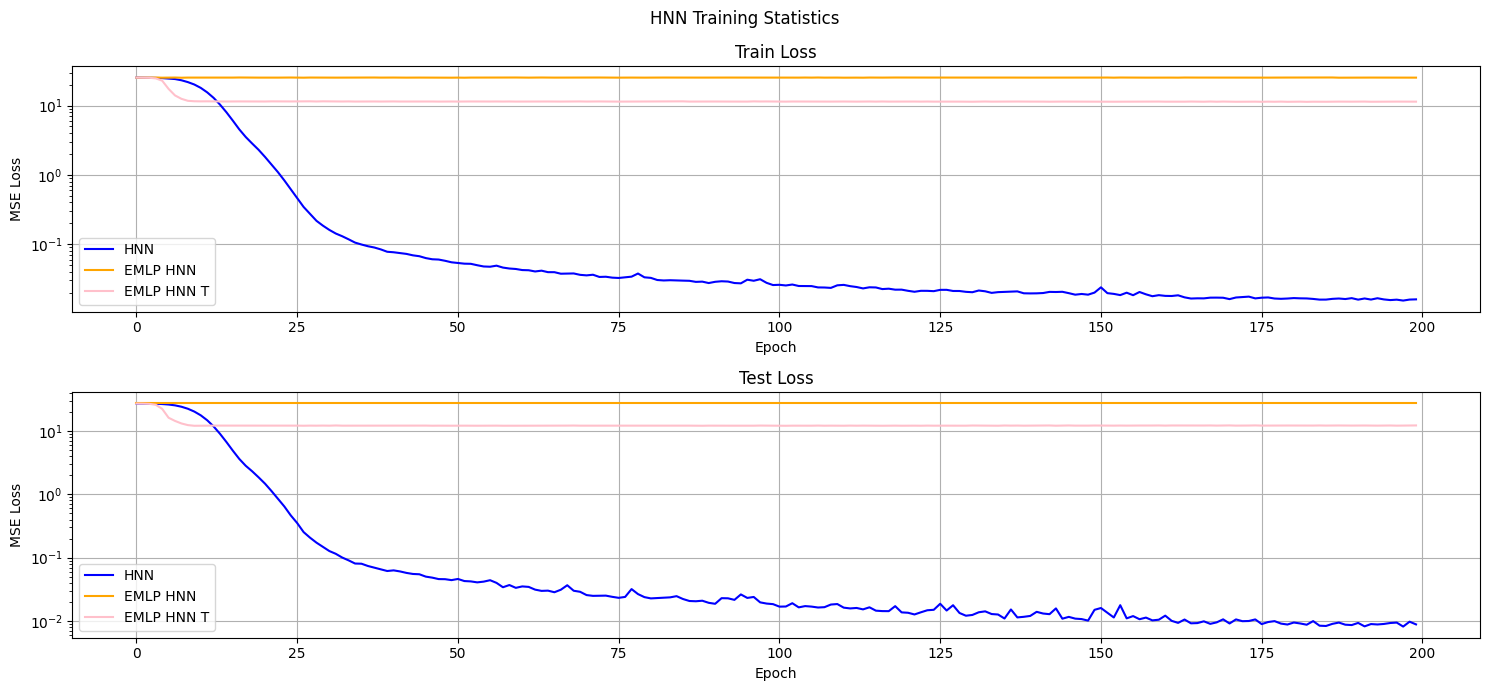

In [15]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats_hnn['train_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['train_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['train_loss'],label='EMLP HNN T',color='pink')

plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats_hnn['test_loss'],label='HNN',color='blue')
plt.plot(stats_hnn_emlp['test_loss'],label='EMLP HNN',color='orange')
plt.plot(stats_hnn_emlp_t['test_loss'],label='EMLP HNN T',color='pink')


plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('HNN Training Statistics')
plt.tight_layout()
plt.show()

In [16]:
# Test the HNN model on a specific initial condition 

print("\nSimulating with trained HNN...")
initial_state = [1.0, 0.0]  # Start at x=1, v=0

# DEBUG: Check that the HNN gives reasonable derivatives at the initial state
initial_tensor = torch.tensor([initial_state], dtype=torch.float32)
initial_tensor.requires_grad_(True)
# Simulate using trained HNN
t_hnn, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 




Simulating with trained HNN...


In [17]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using discovered symmetries...") 

initial_state = [1.0,0.0]

t_hnn_emlp, y_hnn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10],num_points=1000,debug=False)


Simulating with trained EMLP HNN using discovered symmetries...


In [18]:
# Test the EMLP HNN model on a specific initial condition  

print("\nSimulating with trained EMLP HNN using original symmetries...") 

initial_state = [1.0,0.0]

t_hnn_emlp_t, y_hnn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10],num_points=1000,debug=False)


Simulating with trained EMLP HNN using original symmetries...


In [19]:
# Simulate using the original simulator 

from Data.pendulum_dataset import PendulumSimulator 

sim = PendulumSimulator(
    mass=metadata['mass'],
    g=metadata['g'],
    damping=metadata['damping'],
    length=metadata['length']
) 

t_sim, y_sim = sim.simulate(initial_state=initial_state,t_span=[0,10])

y_sim_momentum = np.copy(y_sim) 
y_sim_momentum[:,1] = y_sim_momentum[:,1] * metadata['mass'] 

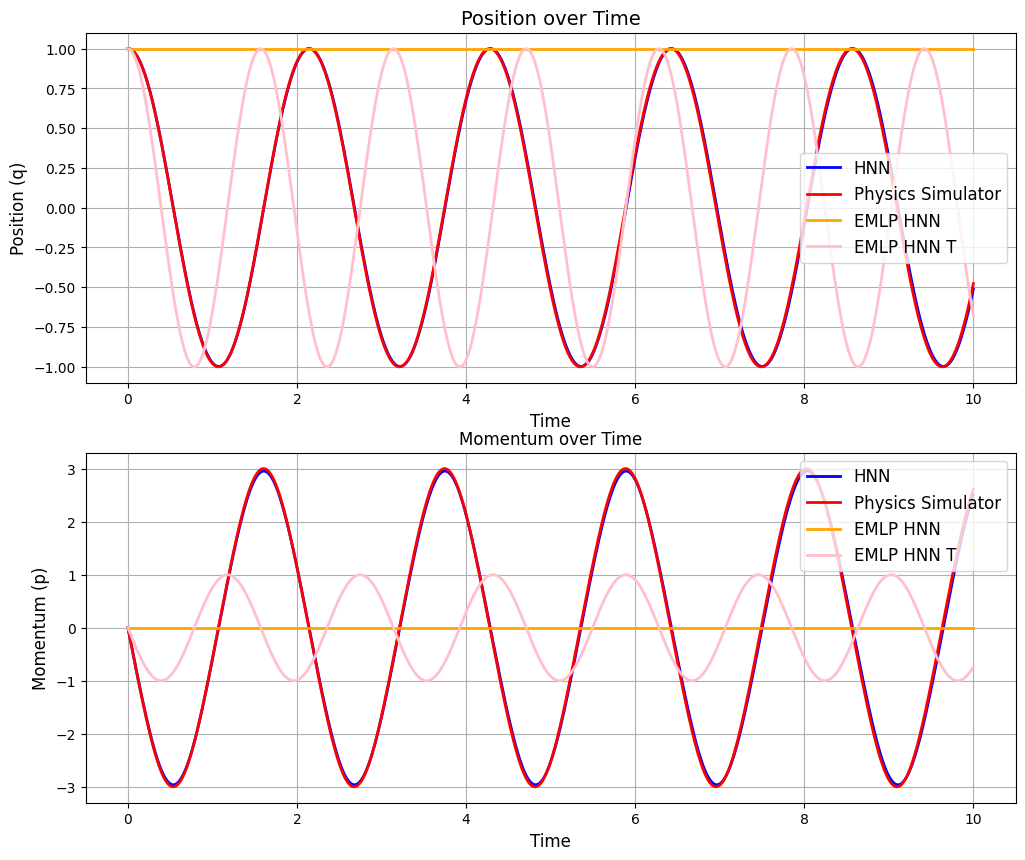

In [20]:
# Plot position and momentum over time
plt.figure(figsize=(12, 10))

# Position over time
plt.subplot(2, 1, 1)
plt.plot(t_hnn, y_hnn[0, :], 'blue', label='HNN', linewidth=2)
plt.plot(t_sim, y_sim[:, 0], 'red', label='Physics Simulator', linewidth=2)
plt.plot(t_hnn_emlp, y_hnn_emlp[0,:], 'orange', label='EMLP HNN', linewidth=2)
plt.plot(t_hnn_emlp_t, y_hnn_emlp_t[0,:], 'pink', label='EMLP HNN T', linewidth=2)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Position (q)', fontsize=12)
plt.title('Position over Time', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Momentum over time
plt.subplot(2, 1, 2)
plt.plot(t_hnn, y_hnn[1, :], 'blue', label='HNN', linewidth=2)
plt.plot(t_sim, y_sim_momentum[:, 1], 'red', label='Physics Simulator', linewidth=2)
plt.plot(t_hnn_emlp, y_hnn_emlp[1,:], 'orange', label='EMLP HNN', linewidth=2)
plt.plot(t_hnn_emlp_t, y_hnn_emlp_t[1,:], 'pink', label='EMLP HNN T', linewidth=2)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Momentum (p)', fontsize=12)
plt.title('Momentum over Time', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

In [21]:
## Computing Error metrics 

n = 5  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'HNN':[],
    'EMLP_HNN':[], 
    'EMLP_HNN_T':[],
}

for idx in indices:
    initial_state = test_coords[idx,0,:]

    _, y_hnn = simulate_hnn(model_hnn, initial_state, (0, 10)) 
    _, y_hhn_emlp = simulate_hnn_emlp_gpu(model_hnn_emlp,initial_state,t_span=[0,10])
    _, y_hhn_emlp_t = simulate_hnn_emlp_gpu(model_hnn_emlp_t,initial_state,t_span=[0,10])

    _, y_sim = sim.simulate(initial_state=initial_state,num_points=1000,t_span=[0,10])

    y_sim[:,1] = y_sim[:,1] * metadata['mass'] 
    y_sim = y_sim.T 



    mse['EMLP_HNN'].append(mse_comp(y_sim,y_hhn_emlp))
    mse['EMLP_HNN_T'].append(mse_comp(y_sim,y_hhn_emlp_t))
    mse['HNN'].append(mse_comp(y_sim,y_hnn))

    


In [22]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

HNN : 0.018199263607638853
EMLP_HNN : 9.25551986694336
EMLP_HNN_T : 6.265340328216553
